In [77]:
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import Sequential
from keras.src.layers import LSTM, Dropout, Dense, GRU
from keras.src.losses import MeanSquaredError, MeanAbsoluteError
from keras.src.metrics import RootMeanSquaredError
from keras.src.optimizers import Adam
from sklearn.model_selection import train_test_split
import keras_tuner as kt

from metrics import ExplainedVarianceScore
import matplotlib.pyplot as plt

keras.utils.set_random_seed(0)

In [50]:
print(f'Num gpus available: {len(tf.config.list_physical_devices("GPU"))}')

Num gpus available: 0


In [51]:
df = pd.read_csv('RV1_SIPIA_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

In [52]:
df.head(10)

,diff_PM10,PM2.5_squared,PM2.5,roll_mean_PM10_7d,cum_count_high_NO2,dew_point_2m (°C),diff_PM2.5,roll_var_PM2.5_7d,PM10
Date,,,,,,,,,
2023-02-15 19:00:00+00:00,-0.066964,0.768199,0.876470,2.163226,1,0.208497,0.016728,0.000276,2.247076
2023-02-15 20:00:00+00:00,-0.066964,0.797803,0.893198,2.163226,2,0.205579,0.016728,0.000276,2.180111
2023-02-15 20:00:00+00:00,0.000000,0.797803,0.893198,2.163226,3,0.205579,0.000000,0.000276,2.180111
2023-02-15 21:00:00+00:00,-0.143066,0.780228,0.883305,2.163226,4,0.205579,-0.009893,0.000276,2.037045
2023-02-15 21:00:00+00:00,0.000000,0.780228,0.883305,2.163226,5,0.205579,0.000000,0.000276,2.037045
2023-02-15 22:00:00+00:00,0.193552,0.842175,0.917701,2.163226,6,0.173654,0.034396,0.000276,2.230597
2023-02-15 22:00:00+00:00,0.000000,0.842175,0.917701,2.163226,7,0.173654,0.000000,0.000276,2.230597
2023-02-15 23:00:00+00:00,-0.193552,0.792005,0.889947,2.133222,8,0.170766,-0.027755,0.000218,2.037045
2023-02-15 23:00:00+00:00,0.000000,0.792005,0.889947,2.112784,9,0.170766,0.000000,0.000224,2.037045


In [53]:
df.describe()

,diff_PM10,PM2.5_squared,PM2.5,roll_mean_PM10_7d,cum_count_high_NO2,dew_point_2m (°C),diff_PM2.5,roll_var_PM2.5_7d,PM10
count,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000
mean,-0.000258,0.220307,0.410996,0.000602,724.163022,0.544101,-0.000039,0.004424,0.000000
std,0.291043,0.195854,0.226713,0.950964,290.288695,0.232600,0.054352,0.008655,1.000089
min,-2.313248,0.000000,0.000000,-2.338911,1.000000,0.000000,-0.467692,0.000000,-2.338911
25%,-0.107611,0.062847,0.250692,-0.708376,640.000000,0.353677,-0.013880,0.000467,-0.706489
50%,0.000000,0.181266,0.425753,0.018244,725.000000,0.602072,0.000000,0.001418,0.020638
75%,0.114477,0.319716,0.565434,0.644836,900.000000,0.742465,0.016575,0.003924,0.693280
max,2.761979,1.000000,1.000000,2.711811,1383.000000,1.000000,0.375968,0.093418,2.994063


In [114]:
df.columns

Index(['diff_PM10', 'PM2.5_squared', 'PM2.5', 'roll_mean_PM10_7d',
       'cum_count_high_NO2', 'dew_point_2m (°C)', 'diff_PM2.5',
       'roll_var_PM2.5_7d', 'PM10'],
      dtype='object')

In [54]:
def createSlidingWinwows(df, windowSize, stepSize=1):
    windows = []
    for start in range(0, len(df) - windowSize + 1, stepSize):
        end = start + windowSize
        window = df.iloc[start:end]
        windows.append(window)
    return windows

In [55]:
def trainTestSplit(windows, target, trainSize=0.8):
    train = windows[:int(len(windows) * trainSize)]
    test = windows[int(len(windows) * trainSize):]

    Xtrain = np.array([window.drop(columns=[target]).values for window in train])
    yTrain = np.array([window[target].values for window in train])

    Xtest = np.array([window.drop(columns=[target]).values for window in test])
    yTest = np.array([window[target].values for window in test])

    return Xtrain, yTrain, Xtest, yTest

In [56]:
windows = createSlidingWinwows(df, 21)
Xtrain, yTrain, Xtest, yTest = trainTestSplit(windows, 'PM10')
Xtrain, Xval, yTrain, yVal = train_test_split(Xtrain, yTrain, test_size=0.2, random_state=0)

In [57]:
print(f'Xtrain shape: {Xtrain.shape}')
print(f'yTrain shape: {yTrain.shape}')
print(f'Xtest shape: {Xtest.shape}')
print(f'yTest shape: {yTest.shape}')
print(f'Xval shape: {Xval.shape}')
print(f'yVal shape: {yVal.shape}')

Xtrain shape: (3587, 21, 8)
yTrain shape: (3587, 21)
Xtest shape: (1121, 21, 8)
yTest shape: (1121, 21)
Xval shape: (897, 21, 8)
yVal shape: (897, 21)


In [58]:
nEpochs = 100

In [59]:
lstm = Sequential()
lstm.add(LSTM(100, input_shape=(21, 8), return_sequences=True))  # 21 steps, 8 features
lstm.add(Dropout(0.3))
lstm.add(LSTM(50))
lstm.add(Dropout(0.3))
lstm.add(Dense(50, activation='relu'))
lstm.add(Dense(21))

lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[
        MeanSquaredError(),
        MeanAbsoluteError(),
        RootMeanSquaredError(),
        ExplainedVarianceScore()
    ]
)

lstmHistory = lstm.fit(
    Xtrain, yTrain,
    epochs=nEpochs,
    batch_size=32,
    validation_data=(Xval, yVal),
    verbose=1,
)

Epoch 1/100
113/113 [==============================] - 7s 40ms/step - loss: 0.7902 - mean_squared_error: 0.7903 - mean_absolute_error: 0.7130 - root_mean_squared_error: 0.8889 - explained_variance_score: 0.1755 - val_loss: 0.7301 - val_mean_squared_error: 0.7175 - val_mean_absolute_error: 0.6852 - val_root_mean_squared_error: 0.8545 - val_explained_variance_score: 0.3058
Epoch 2/100
113/113 [==============================] - 2s 18ms/step - loss: 0.6592 - mean_squared_error: 0.6573 - mean_absolute_error: 0.6528 - root_mean_squared_error: 0.8119 - explained_variance_score: 0.3182 - val_loss: 0.4865 - val_mean_squared_error: 0.4805 - val_mean_absolute_error: 0.5544 - val_root_mean_squared_error: 0.6975 - val_explained_variance_score: 0.3697
Epoch 3/100
113/113 [==============================] - 2s 20ms/step - loss: 0.3080 - mean_squared_error: 0.3068 - mean_absolute_error: 0.4184 - root_mean_squared_error: 0.5549 - explained_variance_score: 0.6534 - val_loss: 0.1838 - val_mean_squared_err

In [60]:
gru = Sequential()
gru.add(GRU(100, input_shape=(21, 8), return_sequences=True))
gru.add(Dropout(0.3))
gru.add(GRU(50))
gru.add(Dropout(0.3))
gru.add(Dense(50, activation='relu'))
gru.add(Dense(21))

gru.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[
        MeanSquaredError(),
        MeanAbsoluteError(),
        RootMeanSquaredError(),
        ExplainedVarianceScore()
    ]
)

gruHistory = gru.fit(
    Xtrain, yTrain,
    epochs=nEpochs,
    batch_size=32,
    validation_data=(Xval, yVal),
    verbose=1,
)

Epoch 1/100
113/113 [==============================] - 6s 23ms/step - loss: 0.8161 - mean_squared_error: 0.8127 - mean_absolute_error: 0.7233 - root_mean_squared_error: 0.9034 - explained_variance_score: 0.1930 - val_loss: 0.7507 - val_mean_squared_error: 0.7398 - val_mean_absolute_error: 0.6983 - val_root_mean_squared_error: 0.8664 - val_explained_variance_score: 0.3820
Epoch 2/100
113/113 [==============================] - 2s 17ms/step - loss: 0.6115 - mean_squared_error: 0.6076 - mean_absolute_error: 0.6203 - root_mean_squared_error: 0.7820 - explained_variance_score: 0.3683 - val_loss: 0.2777 - val_mean_squared_error: 0.2832 - val_mean_absolute_error: 0.4050 - val_root_mean_squared_error: 0.5270 - val_explained_variance_score: 0.8280
Epoch 3/100
113/113 [==============================] - 2s 17ms/step - loss: 0.3024 - mean_squared_error: 0.3012 - mean_absolute_error: 0.4200 - root_mean_squared_error: 0.5499 - explained_variance_score: 0.6791 - val_loss: 0.2405 - val_mean_squared_err

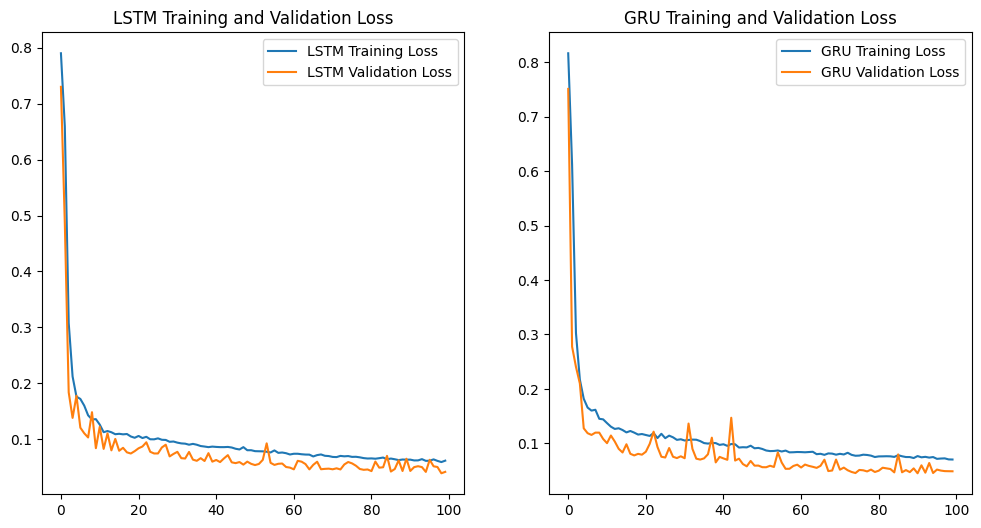

In [76]:
plt.figure(figsize=(12, 6))

# LSTM Losses
plt.subplot(1, 2, 1)
plt.plot(lstmHistory.history['loss'], label='LSTM Training Loss')
plt.plot(lstmHistory.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()

# GRU Losses
plt.subplot(1, 2, 2)
plt.plot(gruHistory.history['loss'], label='GRU Training Loss')
plt.plot(gruHistory.history['val_loss'], label='GRU Validation Loss')
plt.title('GRU Training and Validation Loss')
plt.legend()

plt.show()

In [66]:
lstmPreds = lstm.predict(Xtest)
gruPreds = gru.predict(Xtest)

36/36 [==============================] - 0s 6ms/step


In [144]:
print(Xtest.shape)

(1121, 21, 8)


In [82]:
gruPreds

array([[ 1.3756967 ,  1.3519826 ,  1.2561731 , ..., -1.0065547 ,
        -0.9999386 , -0.94911325],
       [ 1.3316216 ,  1.1884964 ,  1.0035088 , ..., -1.1284525 ,
        -1.124996  , -1.0962032 ],
       [ 1.1160986 ,  0.90601885,  0.6093024 , ..., -1.2390528 ,
        -1.227994  , -1.186854  ],
       ...,
       [-0.7531755 , -0.84968084, -0.8918275 , ...,  1.4272679 ,
         1.2795088 ,  1.18043   ],
       [-0.9971234 , -1.0009844 , -0.9711262 , ...,  1.3109494 ,
         1.1687891 ,  1.1068094 ],
       [-1.1629722 , -1.0864373 , -0.9884351 , ...,  1.1812285 ,
         1.0433177 ,  0.9953046 ]], dtype=float32)

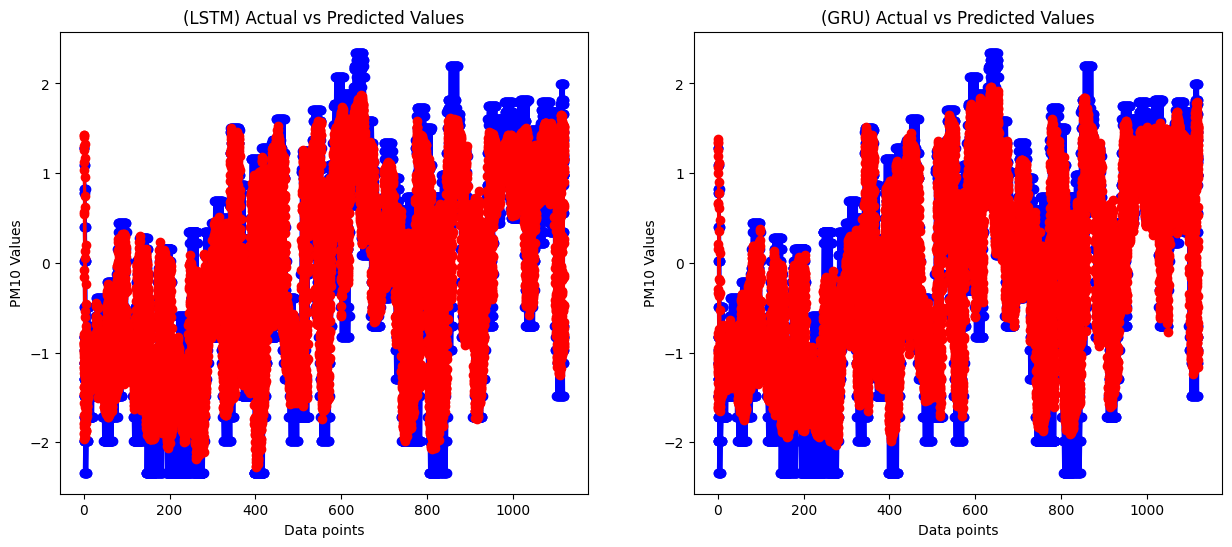

In [75]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(yTest, label='Actual', linestyle='-', marker='o', color='b')
plt.plot(lstmPreds, label='Predicted', linestyle='-', marker='o', color='r')
plt.title('(LSTM) Actual vs Predicted Values')
plt.xlabel('Data points')
plt.ylabel('PM10 Values')

plt.subplot(1, 2, 2)
plt.plot(yTest, label='Actual', linestyle='-', marker='o', color='b')
plt.plot(gruPreds, label='Predicted', linestyle='-', marker='o', color='r')
plt.title('(GRU) Actual vs Predicted Values')
plt.xlabel('Data points')
plt.ylabel('PM10 Values')

plt.show()

### Tuning GRU

In [80]:
fullWindows = createSlidingWinwows(df, 21)
Xfull = np.array([window.drop(columns=['PM10']).values for window in fullWindows])
yFull = np.array([window['PM10'].values for window in fullWindows])

In [81]:
def buildModel(hp):
    model = Sequential()
    model.add(
        GRU(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_shape=(21, 8), return_sequences=True)
    )
    model.add(Dropout(hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(GRU(units=hp.Int('units2', min_value=32, max_value=512, step=32)))
    model.add(Dropout(hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(21))

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mean_squared_error',
        metrics=[MeanSquaredError(), MeanAbsoluteError(), RootMeanSquaredError(), ExplainedVarianceScore()]
    )
    return model

tuner = kt.BayesianOptimization(
    buildModel,
    objective='val_loss',
    max_trials=10,
    directory='tuning',
    project_name='gru-tuning'
)

tuner.search(Xtrain, yTrain, epochs=50, validation_data=(Xval, yVal), verbose=1)

Trial 10 Complete [00h 07m 39s]
val_loss: 0.039659008383750916

Best val_loss So Far: 0.023696208372712135
Total elapsed time: 00h 44m 37s


In [89]:
bestValues = tuner.get_best_hyperparameters(num_trials=1)[0] # num_trials=1 returns the 1 best mode, (2 vrne 2 najboljsa modela)
bestModelTest = tuner.hypermodel.build(bestValues)

In [146]:
print(bestValues.values)

{'units1': 320, 'dropout1': 0.0, 'units2': 256, 'dropout2': 0.30000000000000004, 'dense_units': 192, 'learning_rate': 0.001}


In [90]:
bestModelTestHistory = bestModelTest.fit(
    Xtrain, yTrain, 
    epochs=100, 
    batch_size=32, 
    verbose=1, 
    validation_data=(Xval, yVal)
)

Epoch 1/100
113/113 [==============================] - 9s 52ms/step - loss: 0.7580 - mean_squared_error: 0.7576 - mean_absolute_error: 0.7003 - root_mean_squared_error: 0.8706 - explained_variance_score: 0.2817 - val_loss: 0.7354 - val_mean_squared_error: 0.7194 - val_mean_absolute_error: 0.6721 - val_root_mean_squared_error: 0.8576 - val_explained_variance_score: 0.2978
Epoch 2/100
113/113 [==============================] - 5s 43ms/step - loss: 0.6721 - mean_squared_error: 0.6733 - mean_absolute_error: 0.6609 - root_mean_squared_error: 0.8198 - explained_variance_score: 0.3277 - val_loss: 0.7276 - val_mean_squared_error: 0.7229 - val_mean_absolute_error: 0.7070 - val_root_mean_squared_error: 0.8530 - val_explained_variance_score: 0.3282
Epoch 3/100
113/113 [==============================] - 5s 40ms/step - loss: 0.3314 - mean_squared_error: 0.3299 - mean_absolute_error: 0.4327 - root_mean_squared_error: 0.5757 - explained_variance_score: 0.6505 - val_loss: 0.3022 - val_mean_squared_err

In [91]:
bestTestPreds = bestModelTest.predict(Xtest)

36/36 [==============================] - 1s 14ms/step


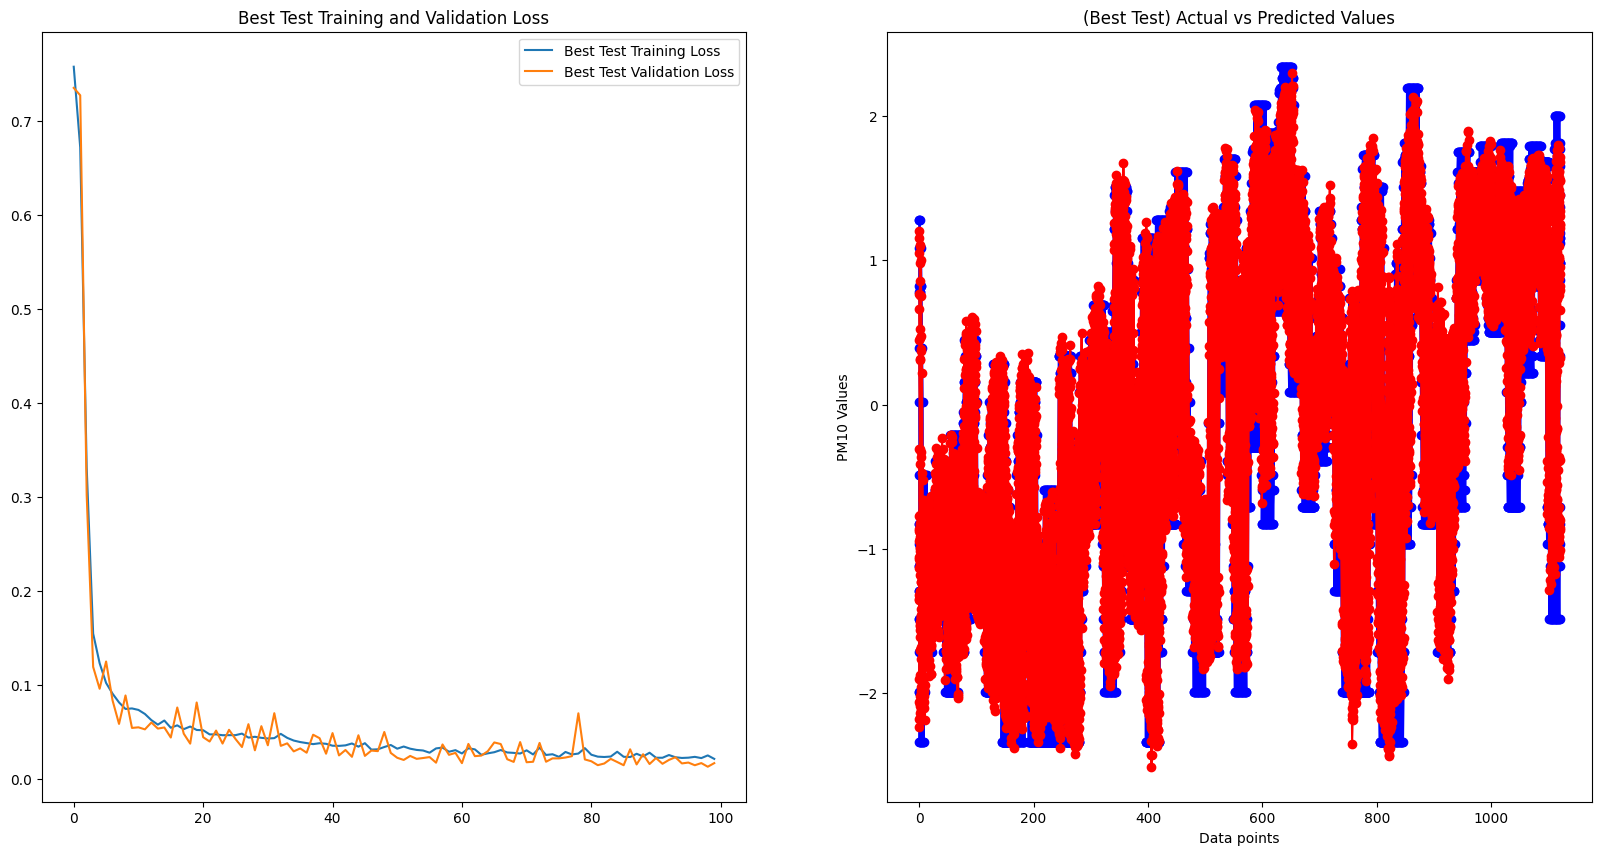

In [102]:
plt.figure(figsize=(20, 10))

# Best Losses
plt.subplot(1, 2, 1)
plt.plot(bestModelTestHistory.history['loss'], label='Best Test Training Loss')
plt.plot(bestModelTestHistory.history['val_loss'], label='Best Test Validation Loss')
plt.title('Best Test Training and Validation Loss')
plt.legend()

# Best Predictions vs Actual
plt.subplot(1, 2, 2)
plt.plot(yTest, label='Actual', linestyle='-', marker='o', color='b')
plt.plot(bestTestPreds, label='Predicted', linestyle='-', marker='o', color='r')
plt.title('(Best Test) Actual vs Predicted Values')
plt.xlabel('Data points')
plt.ylabel('PM10 Values')

plt.show()

In [101]:
bestModel = tuner.hypermodel.build(bestValues)
bestModelHistory = bestModel.fit(
    Xfull, yFull, 
    epochs=100, 
    batch_size=32, 
    verbose=1
)

Epoch 1/100
176/176 [==============================] - 9s 36ms/step - loss: 0.8534 - mean_squared_error: 0.8519 - mean_absolute_error: 0.7494 - root_mean_squared_error: 0.9238 - explained_variance_score: 0.2152
Epoch 2/100
176/176 [==============================] - 6s 36ms/step - loss: 0.5793 - mean_squared_error: 0.5780 - mean_absolute_error: 0.5940 - root_mean_squared_error: 0.7611 - explained_variance_score: 0.4214
Epoch 3/100
176/176 [==============================] - 7s 37ms/step - loss: 0.1758 - mean_squared_error: 0.1755 - mean_absolute_error: 0.3118 - root_mean_squared_error: 0.4193 - explained_variance_score: 0.8231
Epoch 4/100
176/176 [==============================] - 6s 36ms/step - loss: 0.1233 - mean_squared_error: 0.1237 - mean_absolute_error: 0.2607 - root_mean_squared_error: 0.3512 - explained_variance_score: 0.8737
Epoch 5/100
176/176 [==============================] - 6s 36ms/step - loss: 0.1067 - mean_squared_error: 0.1069 - mean_absolute_error: 0.2433 - root_mean_sq

In [115]:
bestModel.save('./objects/air-quality-gru.h5')

In [113]:
n_features = Xtrain.shape[2]  # Replace with the actual number of features

# Creating a single test input window
# This should have the same shape as the windows your model expects (e.g., 21 time steps, n_features features)
testInput = np.random.rand(21, n_features)

# Reshaping testInput to match the input shape of the model
# Assuming your model expects input shape (None, window_size, n_features)
testInput = testInput.reshape(1, 21, n_features)
testInput.shape

(1, 21, 8)

In [143]:
print(bestModel.predict(testInput))
print(testInput.shape)

1/1 [==============================] - 0s 40ms/step
[[ 1.7770004   1.492945    1.3726743   1.2627995   0.8850069   0.75738865
   0.6291378   0.7818457   0.10409757  0.25297806  0.70593625  0.5578264
   0.04051591  0.30880463 -0.21478976 -0.2807535   0.36314273  0.31414622
   0.6084057   0.8029748   1.3954985 ]]
(1, 21, 8)


In [141]:
# from dataprocessing import DataProcessor
# df_test = pd.read_csv('RV1_SIPIA_test.csv')
# df_test['Date'] = pd.to_datetime(df_test['Date'])
# df_test = df_test.sort_values(by='Date')
# df_test.set_index('Date', inplace=True)
# 
# dp = DataProcessor()
# df_test = dp.processDf(df_test)
# 
# len(df_test[0].columns.tolist())
# print(df_test[0].columns.tolist())

bestModel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 21, 320)           316800    
                                                                 
 dropout_12 (Dropout)        (None, 21, 320)           0         
                                                                 
 gru_13 (GRU)                (None, 256)               443904    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 192)               49344     
                                                                 
 dense_13 (Dense)            (None, 21)                4053      
                                                                 
Total params: 814101 (3.11 MB)
Trainable params: 81410